In [1]:
import numpy as np
import matplotlib.pyplot as plt

colors = {
    'red':    '#EC4C4C',   # Light Crimson
    'green':  '#70D07C',   # Clean Apple Green
    'blue':   '#4C9CED',   # Bright Steel Blue
    'yellow': '#FFC857'    # Golden Sun
}

def correlation_ratio(a, b, n_bins=500):
    """
    Compute the correlation ratio (eta squared) between a and b.

    This quantifies the fraction of the variance of a that is explained by b,
    and is normalized between 0 and 1.

    Parameters:
        a : 1D numpy array of dependent variable values (A).
        b : 1D numpy array of independent variable values (B).
        n_bins : number of bins to discretize b (default 10).

    Returns:
        float: the correlation ratio η².
    """
    a = np.asarray(a)
    b = np.asarray(b)

    # Bin b into discrete bins.
    bins = np.linspace(np.min(b), np.max(b), n_bins+1)
    bin_indices = np.digitize(b, bins) - 1

    a_mean = np.mean(a)
    total_var = np.var(a, ddof=1)
    between_var = 0.0

    for i in range(n_bins):
        mask = (bin_indices == i)
        if np.any(mask):
            n_i = np.sum(mask)
            a_bin_mean = np.mean(a[mask])
            between_var += n_i * (a_bin_mean - a_mean)**2

    eta_sq = between_var / ((len(a) - 1) * total_var)
    return np.sqrt(eta_sq)

def generate_correlated(a, eta=0.5, random_seed=None):
    """
    Generate an array b based on input array a such that the squared Pearson
    correlation (R^2) between a and b is approximately eta_squared.

    This function assumes a linear model:
         b = a + noise
    where noise ~ N(0, noise_var) with noise_var chosen so that:
         R^2 = Var(a) / (Var(a) + noise_var) = eta_squared.

    Parameters:
        a : numpy array
            The original continuous data.
        eta : float
            The desired squared correlation between a and b (0 <= eta_squared <= 1).
        random_seed : int or None
            Seed for reproducibility.

    Returns:
        b : numpy array
            The resulting array such that R^2 between a and b is approximately eta_squared.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    if not (0 <= eta <= 1):
        raise ValueError("eta_squared must be between 0 and 1")

    var_a = np.var(a)

    # Handle edge cases:
    if eta == 1:
        # Perfect correlation (noise variance zero)
        return np.copy(a)
    elif eta == 0:
        # No correlation: b should be completely independent noise.
        # We set noise variance equal to var(a) for scaling purposes (choice is arbitrary).
        return np.random.normal(0, np.sqrt(var_a), size=a.shape)

    # Calculate the necessary noise variance to achieve the target eta_squared.
    noise_var = var_a * (1 / eta**2 - 1)

    # Generate noise and add to a.
    noise = np.random.normal(0, np.sqrt(noise_var), size=a.shape)
    b = a + noise
    return b, noise

def sim(q_noise_std):
    N = 50000           # population size
    mu = 0            # mean of structural trait s
    sigma = 10         # standard deviation of s
    q_factor = 1.5

    # Generate population structural trait values
    s = np.random.normal(mu, sigma, N)
    q = np.power(q_factor * (s + np.random.normal(0, q_noise_std, N)), 2)

    s_hat = correlation_ratio(q, s, 400)
    q_hat = correlation_ratio(q, s, 400)

    return s, q, s_hat, q_hat

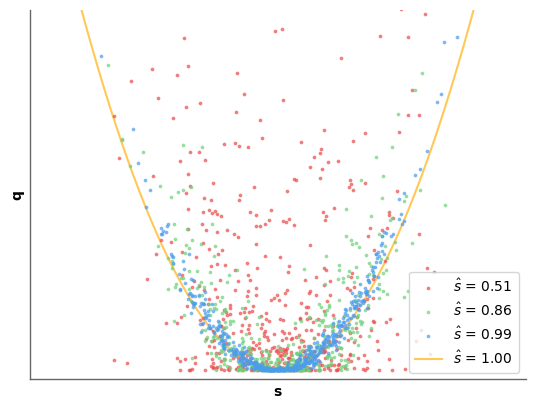

In [3]:
s1, q1, s_hat1, q_hat1 = sim(10)
s2, q2, s_hat2, q_hat2 = sim(4)
s3, q3, s_hat3, q_hat3 = sim(1)

n_shown = 500

# Generate x values (e.g., from -10 to 10)
x = np.linspace(-40, 40, 400)
y = 2*x**2  # Compute y = x^2


plt.rcParams.update({
    "font.family": "sans",
    # "mathtext.fontset": "cm",  # Computer Modern
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'sans',
    'mathtext.it': 'sans:italic',
    'mathtext.bf': 'sans:bold',
    'font.size': 10,
    'font.weight': 'normal',
    'axes.labelweight': 'bold',
    'axes.titlesize': 11,
    'axes.titleweight': 'bold',
})

fig, ax = plt.subplots()
# Hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Style bottom and left spines (x and y axes)
ax.spines['bottom'].set_linewidth(1)
ax.spines['bottom'].set_color('#666')
ax.spines['left'].set_linewidth(1)
ax.spines['left'].set_color('#666')

plt.xticks([])  # Removes x-axis tick labels
plt.yticks([])  # Removes y-axis tick labels

# plt.figure(figsize=(8, 8))
plt.xlim(-40, 40)
plt.ylim(-50, 2000)
plt.scatter(s1[0:n_shown], q1[0:n_shown], label=r"$\hat{s}$ = " + f"{round(s_hat1, 2)}", s=3, color=colors['red'], zorder=2, alpha=0.6)
plt.scatter(s2[0:n_shown], q2[0:n_shown], label=r"$\hat{s}$ = " + f"{round(s_hat2, 2)}", s=3, color=colors['green'], zorder=2, alpha=0.6)
plt.scatter(s3[0:n_shown], q3[0:n_shown], label=r"$\hat{s}$ = " + f"{round(s_hat3, 2)}", s=3, color=colors['blue'], zorder=2, alpha=0.6)

# Plot the curve
plt.plot(x, y, label='$\hat{s}$ = 1.00', color=colors['yellow'], linewidth=1.5, zorder=1)

# plt.plot(q - s, label=r"$q - s$")
plt.xlabel(r"s")
plt.ylabel(r"q")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('plot-qs-distribution.pdf')
plt.show()